# Faraday

This tutorial explains how Faraday works and how to use Faraday to train a generative model and generate synthetic smart meter data.

---

Faraday is a Conditional Variational Auto-Encoder (VAE)-based model. Unlike traditional VAEs where seeds are drawn from a normal distribution and decoded, Faraday works by:
1. First train a VAE using the following loss functions: a. MMD instead of KL-divergence b. Quantile losses and c. Mean squared error
2. Encode real samples to the latent space using the encoder, and fit a Gaussian Mixture Model (GMM) over the latent space.
3. During inference, draw samples from the GMM and decode with the decoder.

For more information on Faraday's architecture, refer to the [Faraday paper](https://arxiv.org/abs/2404.04314).


### Pre-requisites

If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households). 


In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 💿 Loading LCL Data

In [5]:
from pathlib import Path
from src.data_modules.lcl_data_module import LCLDataModule

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train")
stats_path = Path("../../data/processed/historical/train")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm.setup()

# 🤖 VAE Module

In [6]:
from src.models.faraday.model import FaradayVAE
import pytorch_lightning as pl

# Option to pass in your own encoder architecture in the future
model = FaradayVAE(class_dim=2, latent_dim=16, learning_rate=0.001, mse_weight=3)

# Batch size 500 is when MPS becomes faster than CPU..
# But sometimes large batch size hurts convergence..
# Suggest training on CPU with small batch size
# And potentially experiment with best hyperparameters on large batch size before using 'mps'

trainer = pl.Trainer(max_epochs=250, accelerator="cpu")
trainer.fit(model, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /Users/shengchai/Documents/GitHub/OpenSynth/notebooks/faraday/lightning_log

Epoch 249: 100%|██████████| 100/100 [00:01<00:00, 65.39it/s, v_num=0, total_loss=1.230, mmd_loss=0.0181, mse_loss=0.348, quantile_loss=0.867]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 100/100 [00:01<00:00, 64.99it/s, v_num=0, total_loss=1.230, mmd_loss=0.0181, mse_loss=0.348, quantile_loss=0.867]


# 🕸️ GMM Module

In [7]:
from src.models.faraday.model import FaradayModel
import numpy as np
import torch

In [8]:
faraday_model = FaradayModel(vae_module=model, n_components=125, max_iter=10000, tol=1e-5)
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000)
gmm_data_module.setup()

faraday_model.train_gmm(dm=gmm_data_module)

10it [01:31,  9.12s/it]


# 📈 Comparing Results

### 0. Generating Samples

In [9]:
gmm_samples = faraday_model.sample_gmm(n_samples=10000)

gmm_kwh = gmm_samples[0]
gmm_mth = gmm_samples[1]
gmm_dow = gmm_samples[2]
gmm_reconstruct = dm.reconstruct_kwh(gmm_kwh)
gmm_resconstruct = torch.clip(gmm_reconstruct, min=0) # Clip min 0 to get read of negative values

In [59]:
real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))[0])
real_kwh = torch.clip(real_kwh, min=0) # Clip min 0 to get read of negative values

### 1. Comparing mean, 95th quantile, median profiles

Text(0.1, 0.5, 'kWh')

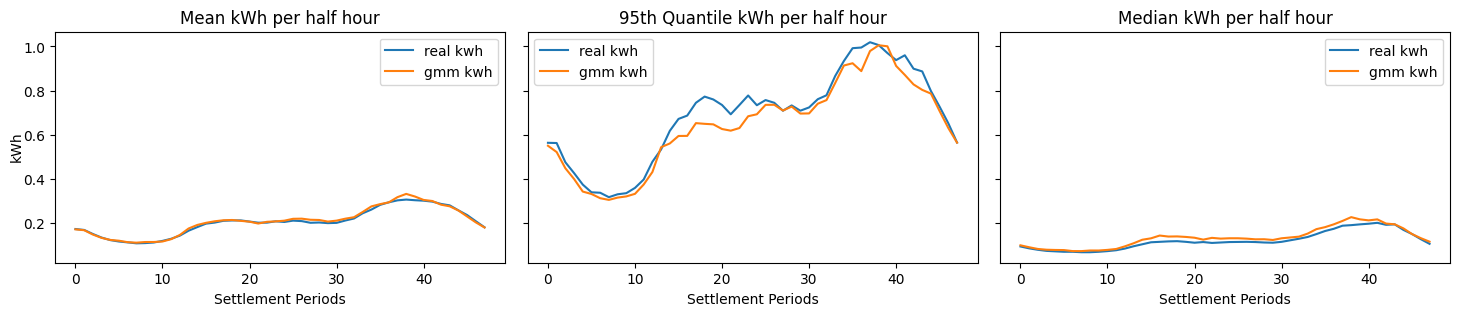

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
ax1.plot(gmm_resconstruct.mean(dim=0).detach().numpy(), label="gmm kwh")
ax1.set_title("Mean kWh per half hour")
ax1.set_xlabel("Settlement Periods")
ax1.legend()

ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
ax2.plot(gmm_resconstruct.quantile(0.95, dim=0).detach().numpy(), label="gmm kwh")
ax2.set_title("95th Quantile kWh per half hour")
ax2.set_xlabel("Settlement Periods")
ax2.legend()

ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
ax3.set_title("Median kWh per half hour")
ax3.set_xlabel("Settlement Periods")
ax3.plot(gmm_resconstruct.quantile(0.5, dim=0).detach().numpy(), label="gmm kwh")
ax3.legend()

fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

### 2. PCA and TSNE Distribution Plots

In [62]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

pca.fit(real_kwh.detach().numpy())
pca_real = pca.transform(real_kwh.detach().numpy())
pca_gmm = pca.transform(gmm_resconstruct.detach().numpy())

tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_resconstruct.detach().numpy()])
tsne_results = tsne.fit_transform(tsne_input)
tsne_real = tsne_results[:len(real_kwh)]
tsne_gmm = tsne_results[len(real_kwh):]

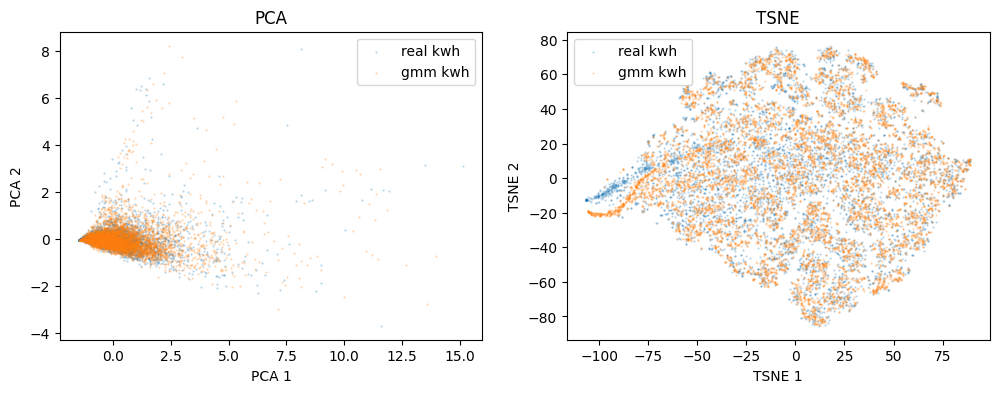

In [75]:
fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.3)
ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.3)
ax_pca.set_title("PCA")
ax_pca.set_xlabel("PCA 1")
ax_pca.set_ylabel("PCA 2")
ax_pca.legend()

ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.3)
ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.3)
ax_tsne.set_title("TSNE")
ax_tsne.set_xlabel("TSNE 1")
ax_tsne.set_ylabel("TSNE 2")
ax_tsne.legend()
